In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [27]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [28]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [30]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data['cnt']
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data['cnt']

In [31]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [32]:
#I'm more accustomed to code with the training examples in columns.
#So, my input vector X has a dimension of (n,m), where n is the number of features and m is the number of training examples
#Same logic goes for my validation and test data sets
X = train_features.T
Y = np.array(train_targets).reshape(1, train_targets.shape[0])
devX = val_features.T
devY = np.array(val_targets).reshape(1, val_targets.shape[0])
testX = test_features.T
testY = np.array(test_targets).reshape(1, test_targets.shape[0])

In [33]:
#Initialize the parameters of the algorithm. I'll make use of python vectorization whenever I can.
#The weights matrix W for any layer l will have a dimension (#hidden units in layer l, #hidden units in layer l-1)
#The bias matrix b for any layer l will have a dimension (#hidden units in layer l, 1)
#The scale factor provided as an argument to this method, decides how big the initial weight values will be -
    # scale_factor = 0.01, a static value to prevent running into the exploding gradients problem
    # scale_factor = sqrt(2/n) as per HE initialization

def initialize_parameters(n_input, n_hidden, n_output, scale_factor):
    W1 = np.random.randn(n_hidden, n_input) * scale_factor
    b1 = np.zeros((n_hidden, 1))
    W2 = np.random.randn(n_output, n_hidden) * scale_factor
    b2 = np.zeros((n_output, 1))
    params = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
    return params

In [34]:
#Vectorized forward propagation

def forward_propagation(params, X):
    W1 = params["W1"]
    b1 = params["b1"]
    #Linear Transformation in layer 1
    Z1 = np.dot(W1, X) + b1
    #Relu activation in layer 1
    A1 = np.maximum(Z1, 0)
    
    W2 = params["W2"]
    b2 = params["b2"]
    #Linear Transformation in layer 2
    Z2 = np.dot(W2, A1) + b2
    A2 = Z2
    
    cache = {"A1" : A1, "Z1" : Z1, "A2" : A2, "Z2" : Z2}
    return cache

In [35]:
def calculate_cost(A2, Y):
    #Cost function defined as mean square error
    return np.mean((A2-Y)**2)

In [36]:
#Vectorized backward propagation
def backward_propagation(params, cache, X, Y):
    m = X.shape[1]
    A2 = cache["A2"]
    A1 = cache["A1"]
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    
    W2 = params["W2"]
    Z1 = cache["Z1"]
    dZ1 = np.dot(W2.T, dZ2) * (Z1 > 0)
    dW1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    gradients = {"dW1" : dW1, "db1" : db1, "dW2" : dW2, "db2" : db2}
    return gradients

In [37]:
#Gradient Descent update
def update_params(gradients, params, learn_rate):
    W1 = params["W1"]
    W2 = params["W2"]
    b1 = params["b1"]
    b2 = params["b2"]
    W1 = W1 - learn_rate * gradients['dW1']
    W2 = W2 - learn_rate * gradients['dW2']
    b1 = b1 - learn_rate * gradients['db1']
    b2 = b2 - learn_rate * gradients['db2']
    parameters = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
    return parameters

In [38]:
#Training a neural network with hyper parameters:
    # n_epochs - number of gradient descent steps
    # n_hidden - number of hidden layer units
    # learn_rate

def train(X, Y, n_epochs, n_hidden, learn_rate, scale_factor):
    n_input = X.shape[0]
    n_output = 1
    params = initialize_parameters(n_input, n_hidden, n_output, scale_factor)
    
    costs = []
    for i in range(1, n_epochs):
        cache = forward_propagation(params, X)
        
        cost = calculate_cost(cache["A2"], Y)
        costs.append(cost)
        
        gradients = backward_propagation(params, cache, X, Y)
        
        params = update_params(gradients, params, learn_rate)
        
        #if (i+1)%100 == 0:
            #print("Cost after " + str(i+1) + "th epoch:" + str(cost))

#    plt.plot(np.arange(1, n_epochs), costs, 'r')
#    plt.show()
    return params

In [39]:
#Tuning the hyper parameters and evaluating multiple models on a validation data set.
#Train the neural network for various values of hyper parameters and choose the best values that perform well
#on the validation set

HE_INITIALIZER = np.sqrt(2/X.shape[0])

learn_rates = [0.4]
#learn_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

n_hidden_units = [4]
#n_hidden_units = [2, 3, 4, 5]

n_epochs = [1500]
#n_epochs = [500, 600, 1000, 1200, 1500]

scale_factors = [0.01]
#scale_factors = [0.01, HE_INITIALIZER]

for lr in learn_rates:
    for nhu in n_hidden_units:
        for ne in n_epochs:
            for sf in scale_factors:
                
                #training the neural network. returns the learnable parameters as output
                params = train(X, Y, ne, nhu, lr, sf)

                #calculate the cost on the training set
                train_cache = forward_propagation(params, X)
                train_cost = calculate_cost(train_cache["A2"], Y)

                #calculate the cost on the validation set
                dev_cache = forward_propagation(params, devX)
                dev_cost = calculate_cost(dev_cache["A2"], devY)
                
                #perform manual bias-variance analysis to see which combination of the hyper parameters works best.

                print("learn rate: " + str(lr) + " number of hidden units: " + str(nhu) + " number of epochs: " + str(ne) +
                      " scale_factor: " + str(sf))
                print("cost on training set: " + str(train_cost))
                print("cost on dev set: " + str(dev_cost))
                print("-----------------------------------------------------------------")

learn rate: 0.4 number of hidden units: 4 number of epochs: 1500 scale_factor: 0.01
cost on training set: 0.08503973925789599
cost on dev set: 0.1752270754904629
-----------------------------------------------------------------


cost on test set: 0.2402690767584069


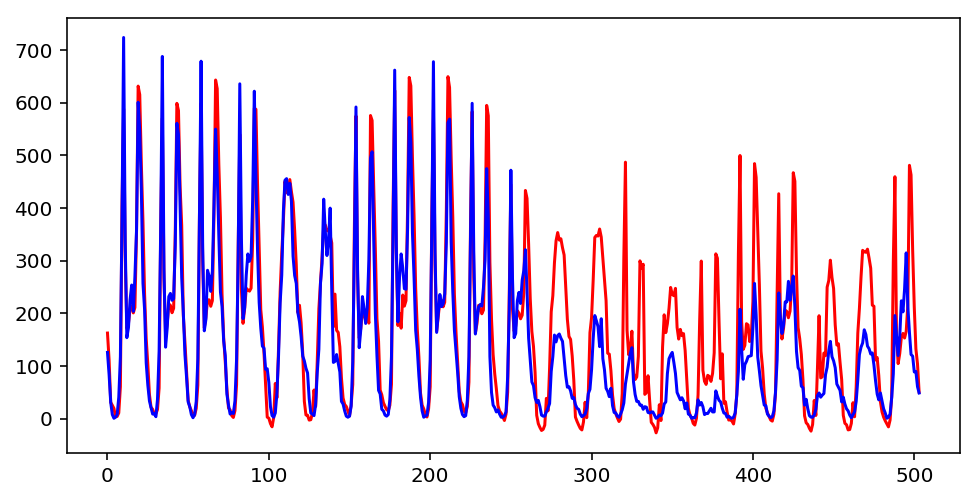

In [40]:
#Apply forward propagation to the test data set 
test_cache = forward_propagation(params, testX)
A2 = test_cache["A2"]

#Calculate the cost on the test data set
test_cost = calculate_cost(A2, testY)
print("cost on test set: " + str(test_cost))

#Plot predictions and actual values
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = A2 * std + mean
testY = testY * std + mean

plt.plot(predictions.T, 'r')
plt.plot(testY.T, 'b')
plt.show()